# Time series forecasting

# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


# Time series analysis

## Plot time series data

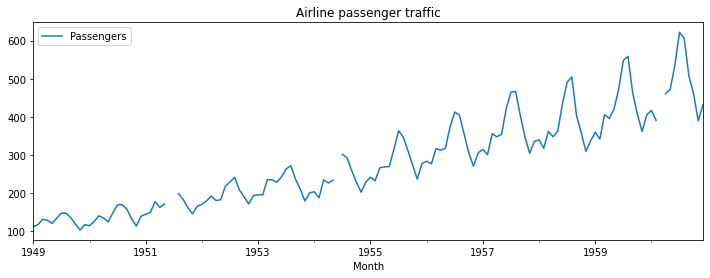

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

## Missing value treatment

### Mean imputation

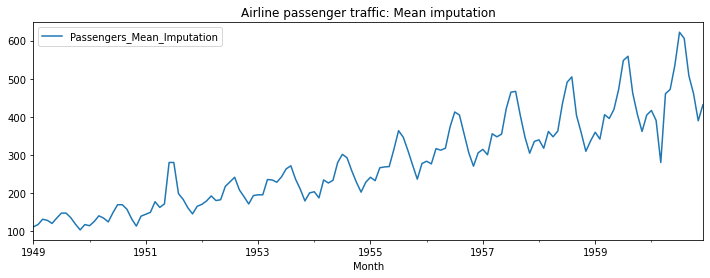

In [4]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

### Linear interpolation

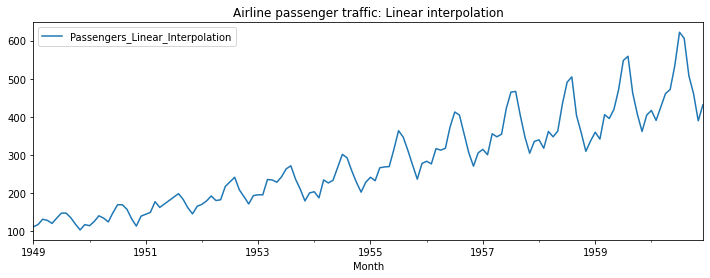

In [5]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

### Use linear interpolation to impute missing values

In [6]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## Outlier detection

### Box plot and interquartile range

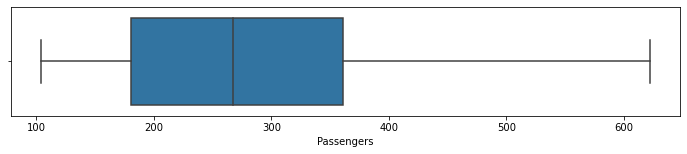

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

### Histogram plot

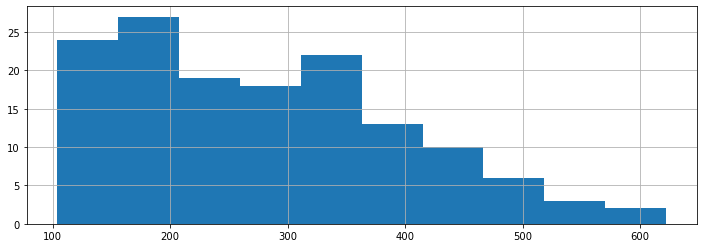

In [8]:
fig = data.Passengers.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

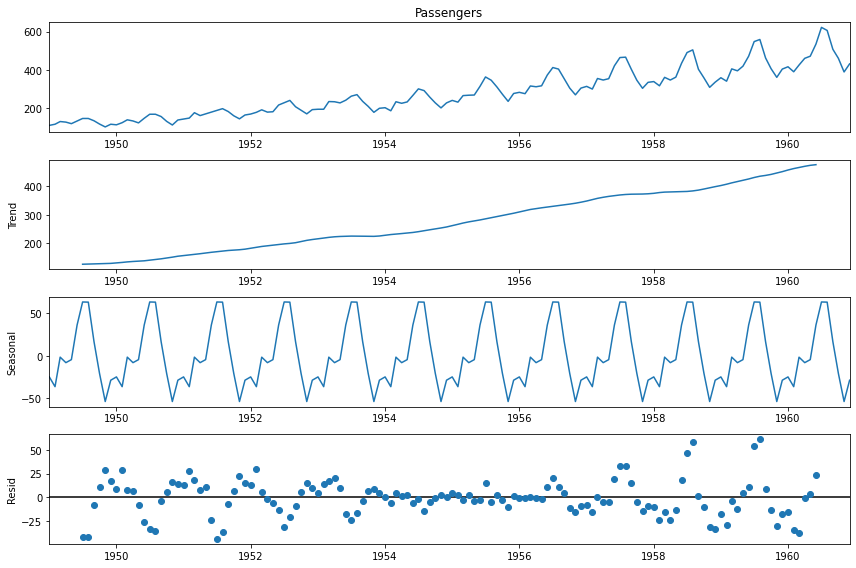

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

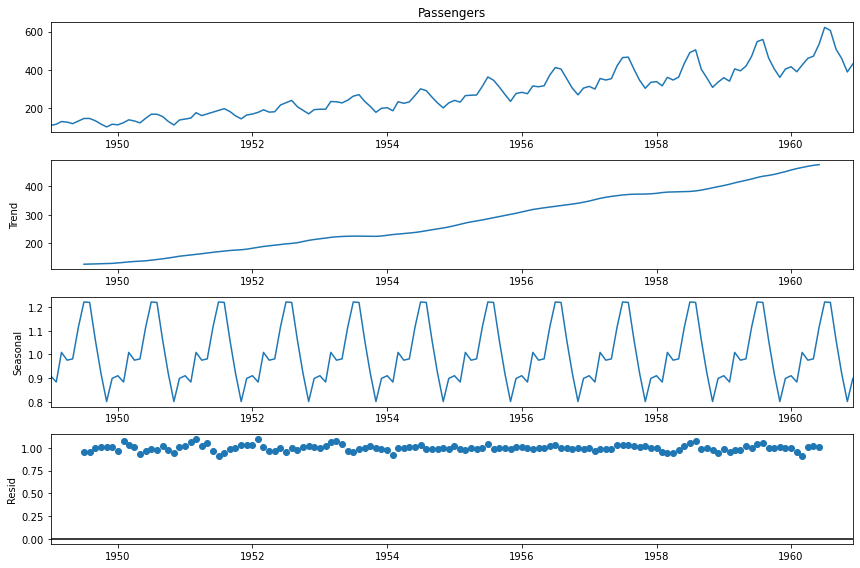

In [10]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [11]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

# Simple time series methods

## Naive method

In [12]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

### Plot train, test and forecast

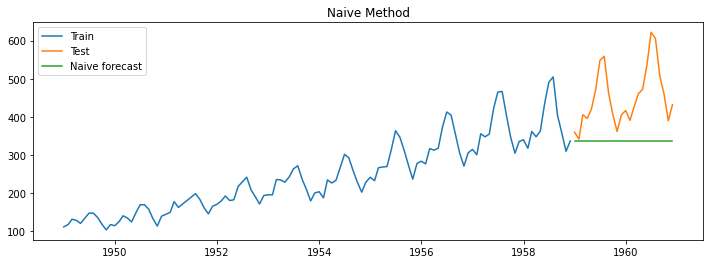

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63


## Simple average method

In [15]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

### Plot train, test and forecast

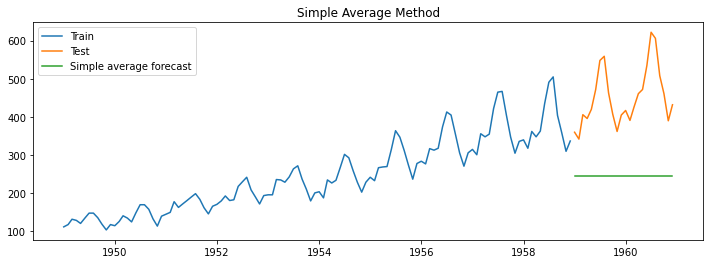

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [17]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28


## Simple moving average method

In [18]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

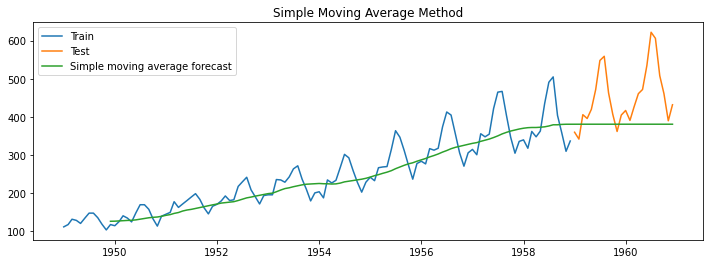

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54


# Exponential smoothing methods

## Simple exponential smoothing

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Plot train, test and forecast

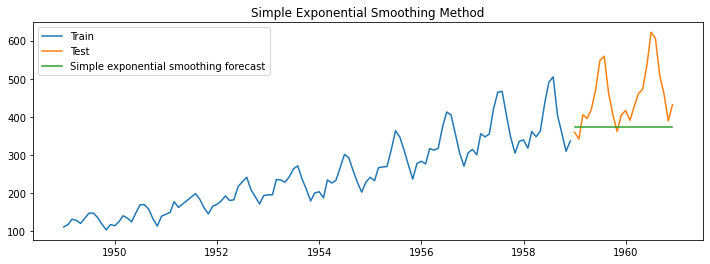

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [23]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49


## Holt's method with trend

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

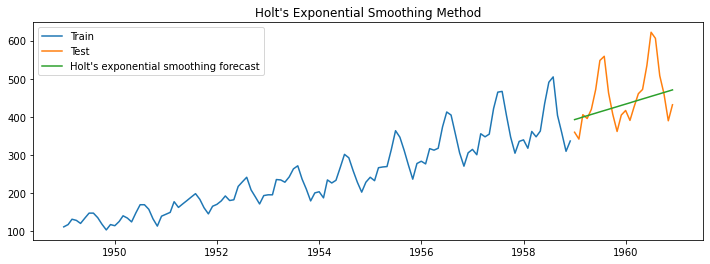

In [25]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11


## Holt Winters' additive method with trend and seasonality

In [27]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.26315789314098964, 'smoothing_slope': 0.05162964592350308, 'smoothing_seasonal': 0.7368421036673054, 'damping_slope': nan, 'initial_level': 211.55098651691858, 'initial_slope': 1.7392009583680696, 'initial_seasons': array([-100.18118124,  -94.2046449 ,  -80.29175411,  -83.4175839 ,
        -91.45908162,  -77.45094413,  -64.48324476,  -64.57340812,
        -76.66644557,  -93.73584622, -108.6761136 ,  -94.50947864]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


### Plot train, test and forecast

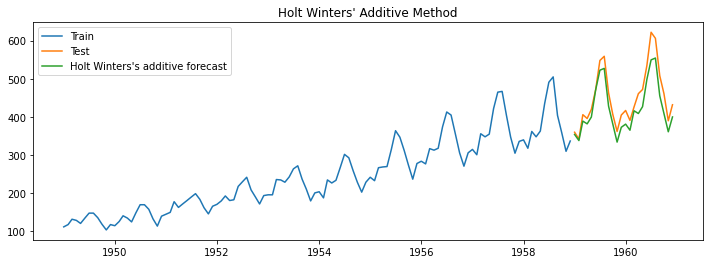

In [28]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53


## Holt Winter's multiplicative method with trend and seasonality

In [30]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.31585252664711466, 'smoothing_slope': 0.05260407593502123, 'smoothing_seasonal': 0.6841473004052635, 'damping_slope': nan, 'initial_level': 212.39886182852717, 'initial_slope': 1.091942938491479, 'initial_seasons': array([0.52244147, 0.54611609, 0.60135025, 0.57253734, 0.52965701,
       0.591542  , 0.65203021, 0.65169644, 0.59645554, 0.51916249,
       0.45990446, 0.53231537]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

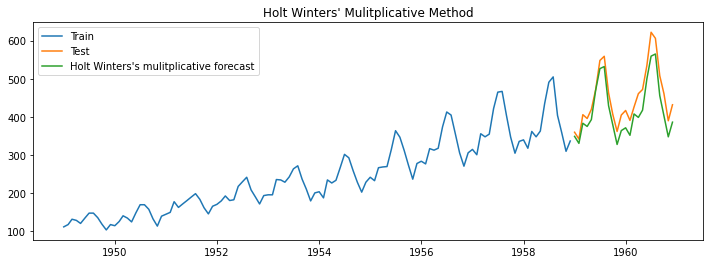

In [31]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,38.33,7.65


# Augmented Dickey

In [33]:

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Stat: %f' % adf_test[0])
print('critical value: %0.2f' % adf_test[4]['5%'])
print('p value: %f ' % adf_test[1])

ADF Stat: 0.894609
critical value: -2.88
p value: 0.993020 


In [34]:
### KPSS
##Augmented Dickey
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('ADF Stat: %f' % kpss_test[0])
print('critical value: %0.2f' % kpss_test[3]['5%'])
print('p value: %f ' % kpss_test[1])

ADF Stat: 1.052050
critical value: 0.46
p value: 0.010000 


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [35]:
new_data=pd.read_csv('./exchange-rate-twi.csv')
new_data.head()

,Month,Exchange Rate TWI
0,1,100.0
1,2,99.6
2,3,99.4
3,4,99.1
4,5,99.2


In [36]:
## ADF
adf_test2 = adfuller(new_data['Exchange Rate TWI'])

print('ADF Stat: %f' % adf_test2[0])
print('critical value: %0.2f' % adf_test2[4]['5%'])
print('p value: %f ' % adf_test2[1])

ADF Stat: -0.805468
critical value: -2.87
p value: 0.817511 


In [37]:
kpss_test2 = kpss(new_data['Exchange Rate TWI'])

print('kpss Stat: %f' % kpss_test2[0])
print('critical value: %0.2f' % kpss_test2[3]['5%'])
print('p value: %f ' % kpss_test2[1])

kpss Stat: 1.725897
critical value: 0.46
p value: 0.010000 


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


No handles with labels found to put in legend.


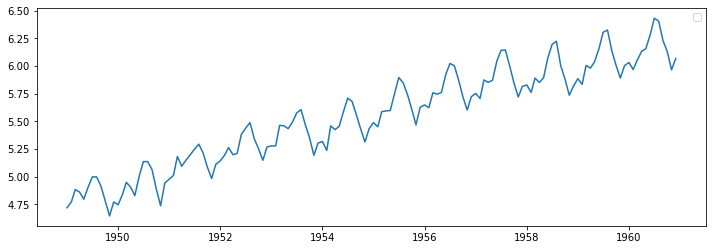

In [38]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index=data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox)
plt.legend(loc='best')
plt.show()

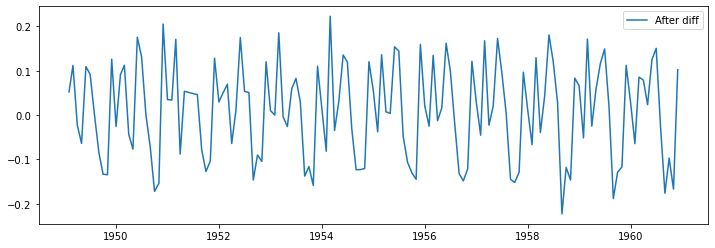

In [39]:
### differencing
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= data.index)

data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After diff')
plt.legend(loc='best')
plt.show()

In [40]:
## ADF
adf_test_boxcox = adfuller(data_boxcox_diff)

print('ADF Stat: %f' % adf_test_boxcox[0])
print('critical value: %0.2f' % adf_test_boxcox[4]['5%'])
print('p value: %f ' % adf_test_boxcox[1])

ADF Stat: -3.290114
critical value: -2.88
p value: 0.015326 


In [41]:
kpss_test_boxcox = kpss(data_boxcox_diff)

print('kpss Stat: %f' % kpss_test_boxcox[0])
print('critical value: %0.2f' % kpss_test_boxcox[3]['5%'])
print('p value: %f ' % kpss_test_boxcox[1])

kpss Stat: 0.101871
critical value: 0.46
p value: 0.100000 


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Autocorrelation

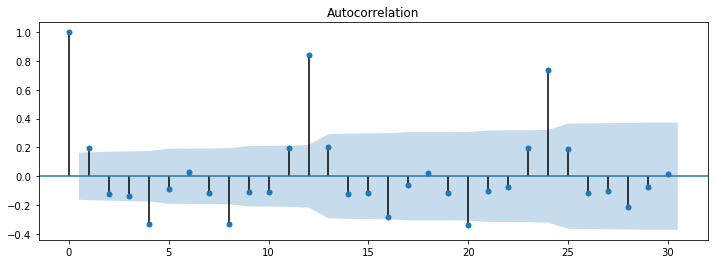

In [42]:
###
from statsmodels.graphics.tsaplots import plot_acf
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
# plt.legend(loc='best')
plt.show()

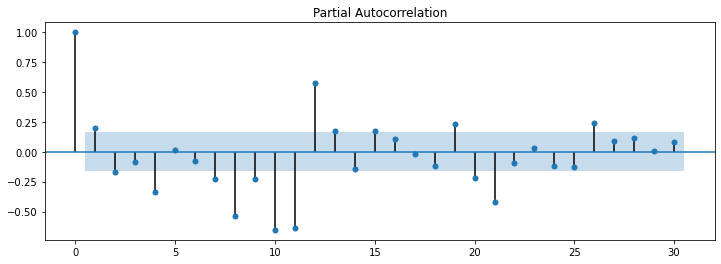

In [43]:
### Partial ACF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
# plt.legend(loc='best')
plt.show()

# Building Autoregressive Model

In [44]:
### splitting into training and testing set

train_data_boxcox = data_boxcox[:train_len]
test_train_boxcox = data_boxcox[train_len:]


train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_train_boxcox_diff = data_boxcox_diff[train_len-1:]

In [45]:
## AR Model
from statsmodels.tsa.arima_model import ARIMA
model_ar = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_ar_fit = model_ar.fit()
print(model_ar_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [46]:
### Recover OriOriginal time series
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_ar_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

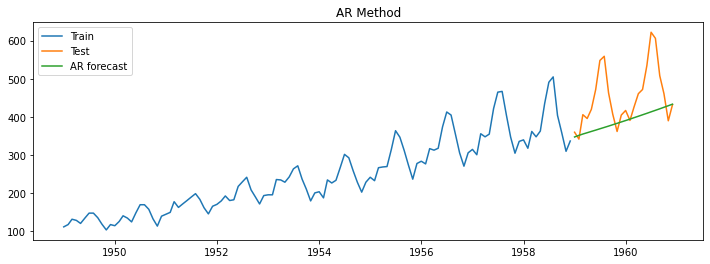

In [47]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='AR forecast')
plt.legend(loc='best')
plt.title('AR Method')
plt.show()

In [48]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['AR method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,38.33,7.65
0,AR method,93.39,13.77


In [49]:
### Moving average

model_sales=ARIMA(train_data_boxcox_diff,order=(0,0,1))
model_sales_fit=model_sales.fit()
print(model_sales_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.009538
ma.L1.y    0.266103
dtype: float64


In [50]:
### Recover OriOriginal time series
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_sales_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

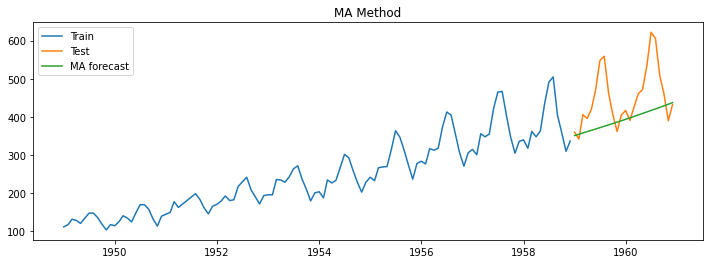

In [51]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='MA forecast')
plt.legend(loc='best')
plt.title('MA Method')
plt.show()

In [52]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['MA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,38.33,7.65
0,AR method,93.39,13.77
0,MA method,91.21,13.39


# Sales data

In [53]:
data_sales = pd.read_csv('sales-data.csv')
data_sales.head()

,month,sales
0,1980-01,154
1,1980-02,96
2,1980-03,73
3,1980-04,49
4,1980-05,36


In [54]:

# data_sales_boxcox = pd.Series(boxcox(data_sales['sales'], lmbda=0), index=data.index)

# plt.figure(figsize=(12,4))
# plt.plot(data_sales_boxcox)
# plt.legend(loc='best')
# plt.show()

# ARMA

In [55]:
model_arma = ARIMA(train_data_boxcox_diff,order=(1,0,1))
model_arma_fit=model_arma.fit()
print(model_arma_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


In [56]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_sales_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

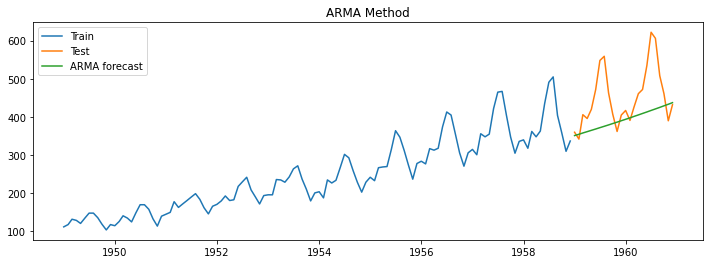

In [57]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['ARMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,38.33,7.65
0,AR method,93.39,13.77
0,MA method,91.21,13.39
0,ARMA method,91.21,13.39


# ARIMA

In [59]:
model_arima = ARIMA(train_data_boxcox,order=(1,1,1))
model_arima_fit=model_arima.fit()
print(model_arima_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


# URATE

In [60]:
data = pd.read_csv('UNRATE.csv', header = None)
data.columns = ['Month','UNRATE']
data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head(12)

,UNRATE
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


In [61]:
train_len = 612
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

In [62]:
len(test)

255

No handles with labels found to put in legend.


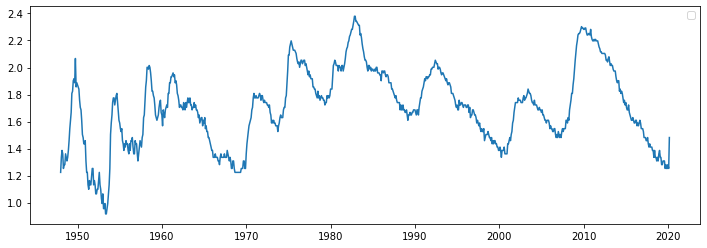

In [63]:
from scipy.stats import boxcox

data_boxcox = pd.Series(boxcox(data['UNRATE'], lmbda=0), index=data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox)
plt.legend(loc='best')
plt.show()

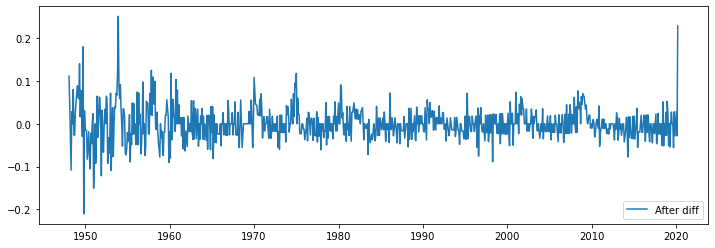

In [64]:
### differencing
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= data.index)

data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After diff')
plt.legend(loc='best')
plt.show()

In [65]:
data_boxcox_diff.head()

Month
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
dtype: float64

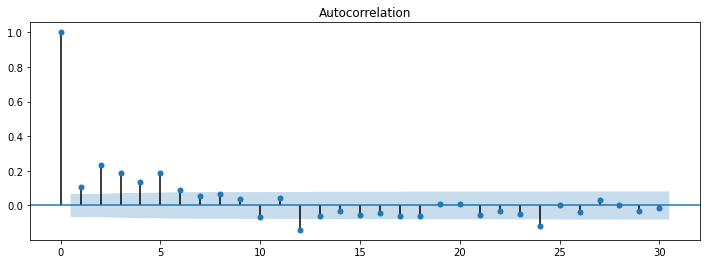

In [66]:
###
from statsmodels.graphics.tsaplots import plot_acf
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
# plt.legend(loc='best')
plt.show()

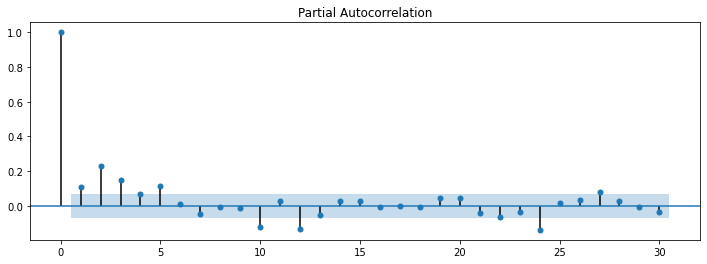

In [67]:
### Partial ACF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
# plt.legend(loc='best')
plt.show()

In [68]:
train_data_boxcox = data_boxcox[:train_len]
test_train_boxcox = data_boxcox[train_len:]


train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_train_boxcox_diff = data_boxcox_diff[train_len-1:]

In [69]:
## AR Model
from statsmodels.tsa.arima_model import ARIMA
model_ar = ARIMA(train_data_boxcox_diff, order=(12,0,0))
model_ar_fit = model_ar.fit()
print(model_ar_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


In [70]:
### Recover OriOriginal time series
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_ar_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [71]:
y_hat_ar.ar_forecast.head(20)

1948-02-01    3.901819
1948-03-01    3.960922
1948-04-01    4.082803
1948-05-01    4.188015
1948-06-01    4.210204
1948-07-01    4.179055
1948-08-01    4.151684
1948-09-01    4.106119
1948-10-01    4.113307
1948-11-01    4.144531
1948-12-01    4.094550
1949-01-01    4.115291
1949-02-01    4.118995
1949-03-01    4.224512
1949-04-01    4.365250
1949-05-01    4.609620
1949-06-01    4.730192
1949-07-01    4.986641
1949-08-01    5.122436
1949-09-01    5.301911
Freq: MS, dtype: float64

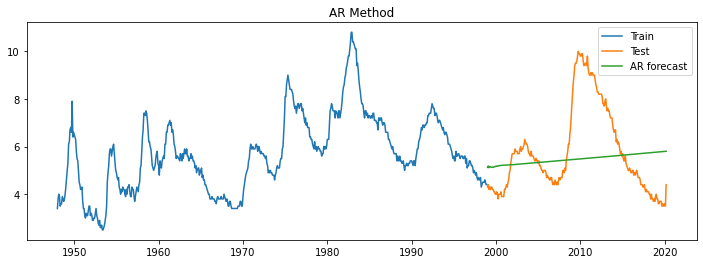

In [72]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='AR forecast')
plt.legend(loc='best')
plt.title('AR Method')
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ar['ar_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['AR - UNRATE-  method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1.83,23.62
0,AR - UNRATE- method,1.83,23.62


In [74]:
### Moving average

model_sales=ARIMA(train_data_boxcox_diff,order=(0,0,5))
model_sales_fit=model_sales.fit()
print(model_sales_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [75]:
### Recover OriOriginal time series
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_sales_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

In [76]:
y_hat_ma.ma_forecast.head(20)

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
1948-07-01    4.109965
1948-08-01    4.074681
1948-09-01    4.034847
1948-10-01    4.035718
1948-11-01    4.084505
1948-12-01    4.102314
1949-01-01    4.161209
1949-02-01    4.198595
1949-03-01    4.277789
1949-04-01    4.414816
1949-05-01    4.561282
1949-06-01    4.716618
1949-07-01    4.903868
1949-08-01    5.013272
1949-09-01    5.113709
Freq: MS, dtype: float64

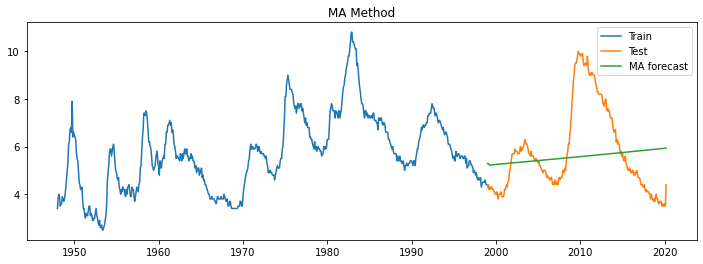

In [77]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='MA forecast')
plt.legend(loc='best')
plt.title('MA Method')
plt.show()

In [78]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ma['ma_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['MA -UNRATE method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1.83,23.62
0,AR - UNRATE- method,1.83,23.62
0,MA -UNRATE method,1.82,24.26


In [79]:
# Arima
model_arima = ARIMA(train_data_boxcox,order=(12,1,5))
model_arima_fit=model_arima.fit()
print(model_arima_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const         0.000458
ar.L1.D.y    -0.094717
ar.L2.D.y     0.667893
ar.L3.D.y     0.485544
ar.L4.D.y    -0.464488
ar.L5.D.y    -0.599782
ar.L6.D.y     0.048886
ar.L7.D.y     0.050334
ar.L8.D.y     0.098754
ar.L9.D.y     0.135081
ar.L10.D.y   -0.047559
ar.L11.D.y    0.007948
ar.L12.D.y   -0.072361
ma.L1.D.y     0.125494
ma.L2.D.y    -0.509285
ma.L3.D.y    -0.360785
ma.L4.D.y     0.516293
ma.L5.D.y     0.668838
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [80]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_sales_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

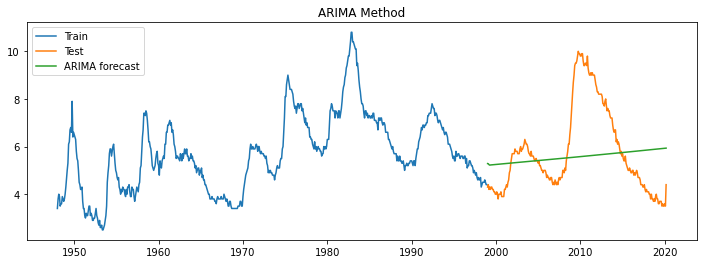

In [81]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

In [82]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_arima['arima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1.83,23.62
0,AR - UNRATE- method,1.83,23.62
0,MA -UNRATE method,1.82,24.26
0,ARIMA method,1.82,24.26


# SARIMA

In [83]:
?? SARIMAX

Object ` SARIMAX` not found.


In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima = SARIMAX(train_data_boxcox,order=(2,1,4), seasonal_order=(2,1,4,12))
model_sarima_fit=model_sarima.fit()
print(model_sarima_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ar.L1       0.597370
ar.L2       0.117325
ma.L1      -0.560896
ma.L2       0.000104
ma.L3       0.068972
ma.L4       0.054452
ar.S.L12   -0.934411
ar.S.L24   -0.511354
ma.S.L12   -0.280068
ma.S.L24   -0.536585
ma.S.L36   -0.399675
ma.S.L48    0.270211
sigma2      0.001496
dtype: float64


In [85]:
y_hat_sarima=data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_sales_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

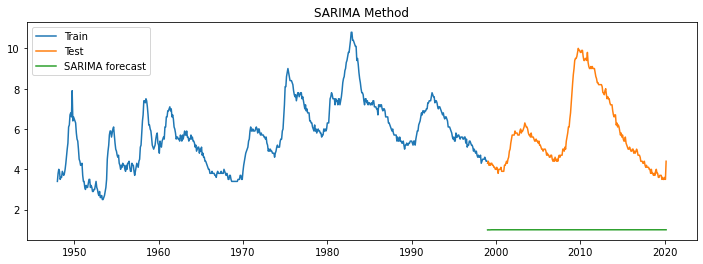

In [86]:
###plotting train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Method')
plt.show()

In [87]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1.83,23.62
0,AR - UNRATE- method,1.83,23.62
0,MA -UNRATE method,1.82,24.26
0,ARIMA method,1.82,24.26
0,SARIMA method,5.11,81.17
